In [1]:
from collections import namedtuple
import random

from gym.wrappers import RescaleAction, TimeLimit
import json
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO, TD3
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from tqdm import tqdm

from environments import ARESEAOneStep, ARESEASequential

In [2]:
with open("problems.json", "r") as f:
    problems = json.load(f)

# Sequential

In [3]:
evaluations = {}

In [4]:
def load_sequential(model_name):

    ModelSetup = namedtuple("ModelSetup", ["name","env","model"])

    log_dir = f"models/{model_name}"

    def make_env():
        env = ARESEASequential(
            backend="simulation",
            backendargs={"measure_beam": "direct"}
        )
        env = TimeLimit(env, max_episode_steps=50)
        env = RescaleAction(env, -1, 1)
        return env

    env = DummyVecEnv([make_env])
    env = VecNormalize.load(f"{log_dir}/vec_normalize.pkl", env)
    env.training = False
    env.norm_reward = False

    model = TD3.load(f"{log_dir}/model")

    return ModelSetup(model_name, env, model)

In [5]:
def run(env, model, problem=None):
    Result = namedtuple("Result", ["initial","achieved","desired"])

    if problem is not None:
        if "initial" in problem:
            env.get_attr("unwrapped")[0].next_initial = problem["initial"]
        if "incoming" in problem:
            env.get_attr("backend")[0].next_incoming = problem["incoming"]
        if "misalignments" in problem:
            env.get_attr("backend")[0].next_misalignments = problem["misalignments"]
        if "desired" in problem:
            env.get_attr("unwrapped")[0].next_desired = problem["desired"]

    observation = env.reset()
    initial = env.unnormalize_obs(observation)[0,-4:]
    desired = env.unnormalize_obs(observation)[0,-8:-4]
    done = False
    while not done:
        action, _ = model.predict(observation, deterministic=True)
        observation, reward, done, info = env.step(action)
    achieved = env.unnormalize_obs(info[0]["terminal_observation"])[-4:]
    
    return Result(initial, achieved, desired)

In [6]:
def evaluate(env, model, n=None, problems=None, misalignments=True, random_initial=False, model_name="Anonymous"):
    assert (n is None) != (problems is None)

    Evaluation = namedtuple("Evaluation", ["model_name","env","results"])

    if problems is None:
        base_problem = {}
        if not misalignments:
            base_problem["misalignments"] = np.zeros(8)
        if not random_initial:
            base_problem["initial"] = np.zeros(5)
        problems = n * [base_problem]

    results = [run(env, model, problem=problem) for problem in tqdm(problems)]

    return Evaluation(model_name, env, results)

In [7]:
def plot_examples(evaluation, k=3):
    samples = random.sample(evaluation.results, k)

    def plot_ellipse(params, color=None, label=None):
        ellipse = Ellipse((params[0],params[1]), params[2], params[3], fill=False, color=color, label=label)
        plt.gca().add_patch(ellipse)

    screen = evaluation.env.get_attr("backend")[0]._segment.AREABSCR1

    plt.figure(figsize=(21,4))
    plt.suptitle(f"Example runs of {evaluation.model_name}")
    for i, sample in enumerate(samples):
        plt.subplot(1, len(samples), i+1)
        plt.title(f"Run {i+1}")
        plt.xlim([screen.extent[0], screen.extent[1]])
        plt.ylim([screen.extent[2], screen.extent[3]])
        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.grid()
        plot_ellipse(sample.initial, color="red", label="Initial")
        plot_ellipse(sample.achieved, color="orange", label="Achieved")
        plot_ellipse(sample.desired, color="green", label="Desired")        
        plt.legend()

In [8]:
def plot_our_objective(evaluations, model_type=None):

    def objective_fn(achieved, desired):
        offset = achieved - desired
        weights = np.array([1, 1, 2, 2])

        return np.log((weights * np.abs(offset)).sum())
    
    plt.figure(figsize=(18,4.5))

    if model_type is not None:
        plt.suptitle(f"Our Objective for {model_type}")
    else:
        plt.suptitle(f"Our Objective")
        
    for i, evaluation in enumerate(evaluations):
        objectives = [objective_fn(result.achieved, result.desired) for result in evaluation.results]

        plt.subplot(1, len(evaluations), i+1)
        plt.title(evaluation.model_name)
        sns.histplot(objectives, bins=20, kde=True)
        plt.xlabel("Achieved Objective")
    plt.tight_layout()
    plt.show()

In [9]:
def plot_mae(evaluations, model_type=None):
    plt.figure(figsize=(18,4.5))

    if model_type is not None:
        plt.suptitle(f"Our Objective for {model_type}")
    else:
        plt.suptitle(f"Our Objective")
        
    for i, evaluation in enumerate(evaluations):
        objectives = [np.abs(result.desired - result.achieved).sum() / 4 for result in evaluation.results]
        
        plt.subplot(1, len(evaluations), i+1)
        plt.title(evaluation.model_name)
        sns.histplot(objectives, bins=20, kde=True)
        plt.xlabel("Achieved Objective")
        plt.xscale("log")
    plt.tight_layout()
    plt.show()

In [45]:
def plot_parameter_errors(results):
    pass

## Default - Trained with Random Initial and No Misalignments for 600k Steps

In [11]:
model_names = ["bright-rain-963", "lyric-wave-964", "pleasant-wood-965"]
setups = [load_sequential(model_name) for model_name in model_names]
evaluations["base"] = [evaluate(setup.env, setup.model, problems=problems, model_name=setup.name) for setup in setups]

100%|██████████| 300/300 [00:21<00:00, 14.10it/s]


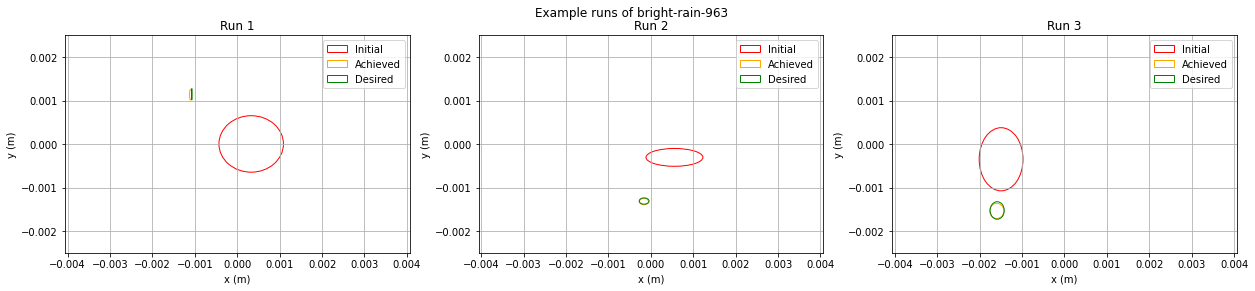

In [12]:
plot_examples(evaluations["base"][0], k=3)

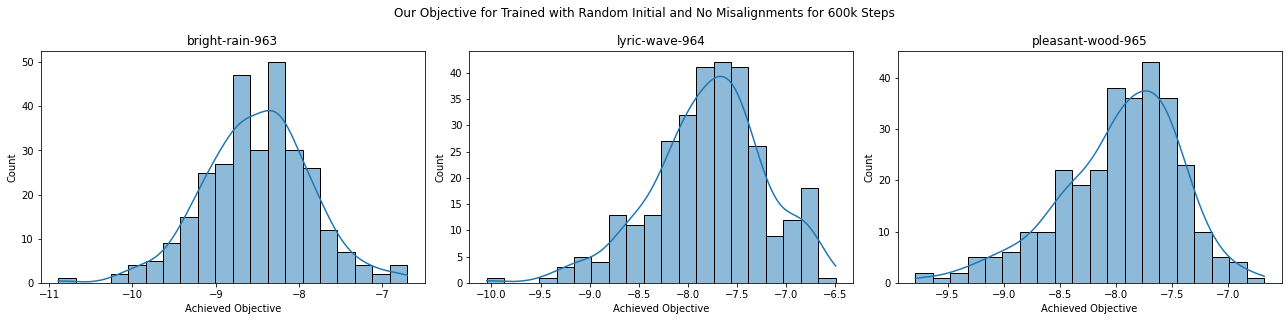

In [46]:
plot_our_objective(evaluations["base"], model_type="Random Initial and Random Incoming at 600k Training")

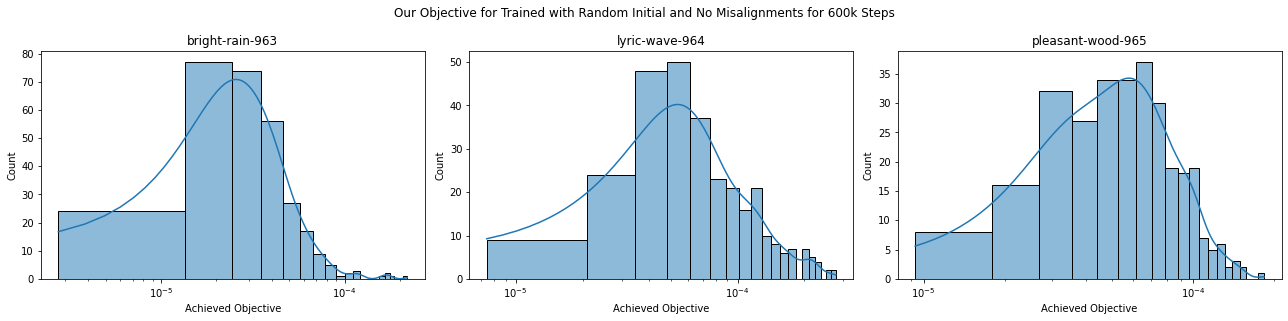

In [47]:
plot_mae(evaluations["base"], model_type="Trained with Random Initial and No Misalignments for 600k Steps")

## Trained 600k With Initial Actuators Set to Zero

In [21]:
model_names = ["faithful-meadow-975", "amber-mountain-976", "ruby-water-977"]
setups = [load_sequential(model_name) for model_name in model_names]
evaluations["reset"] = [evaluate(setup.env, setup.model, problems=problems, model_name=setup.name) for setup in setups]

100%|██████████| 300/300 [00:22<00:00, 13.04it/s]


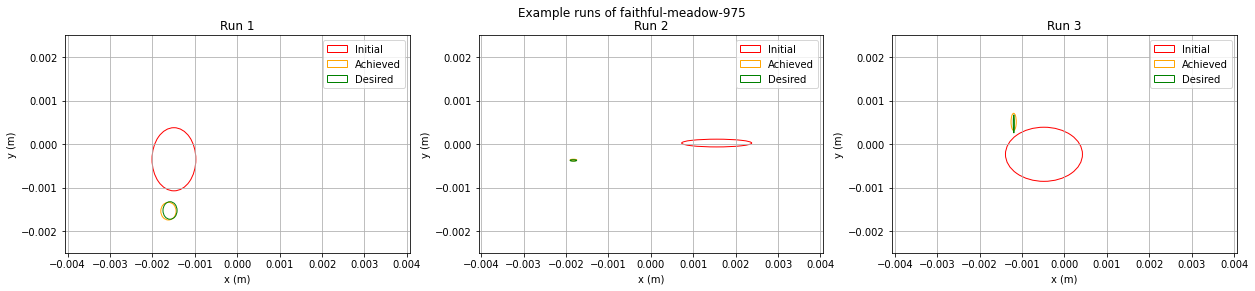

In [22]:
plot_examples(evaluations["reset"][0], k=3)

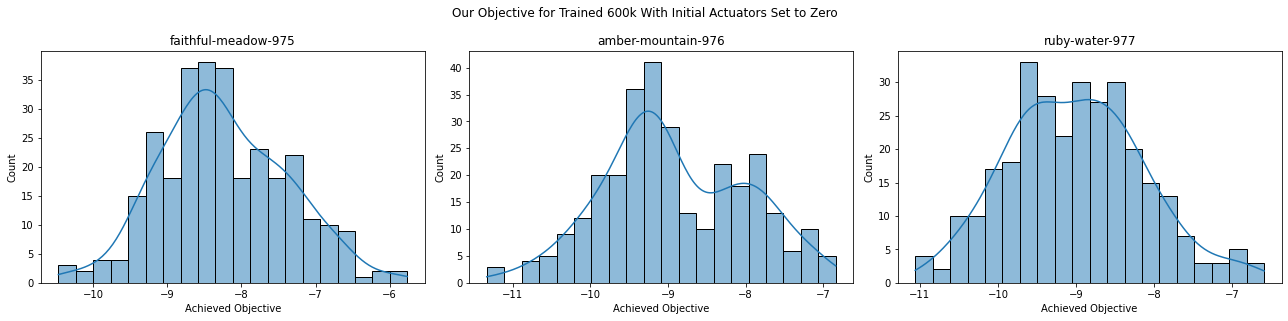

In [48]:
plot_our_objective(evaluations["reset"], model_type="Trained 600k With Initial Actuators Set to Zero")

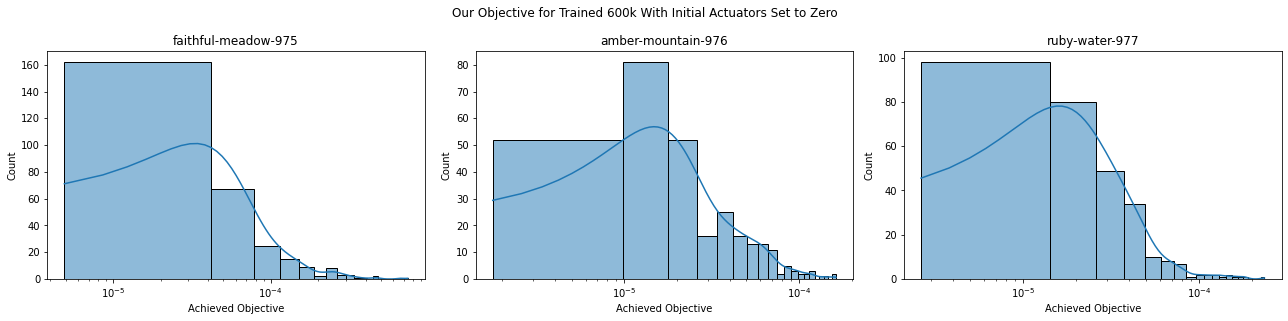

In [49]:
plot_mae(evaluations["reset"], model_type="Trained 600k With Initial Actuators Set to Zero")

## Quadrupole and Screen Misalignments (Up to 400 Micrometers in Both Directions)

In [25]:
model_names = ["ethereal-firefly-972", "royal-planet-973", "clear-armadillo-974"]
setups = [load_sequential(model_name) for model_name in model_names]
evaluations["misalign"] = [evaluate(setup.env, setup.model, problems=problems, model_name=setup.name) for setup in setups]

100%|██████████| 300/300 [00:22<00:00, 13.28it/s]


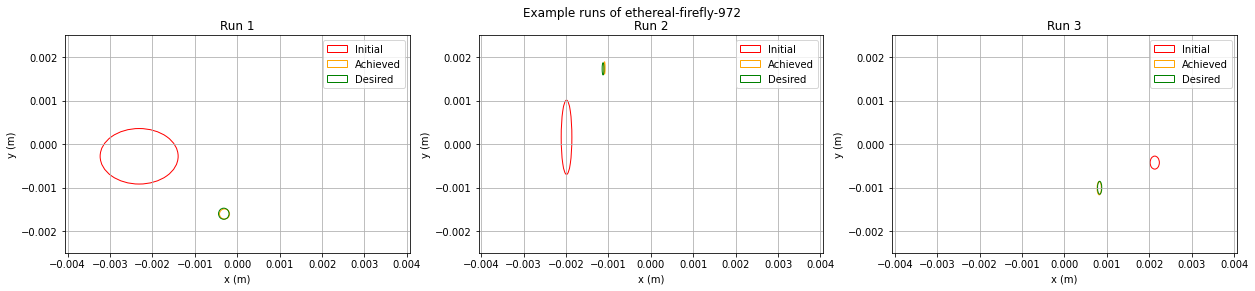

In [26]:
plot_examples(evaluations["misalign"][0], k=3)

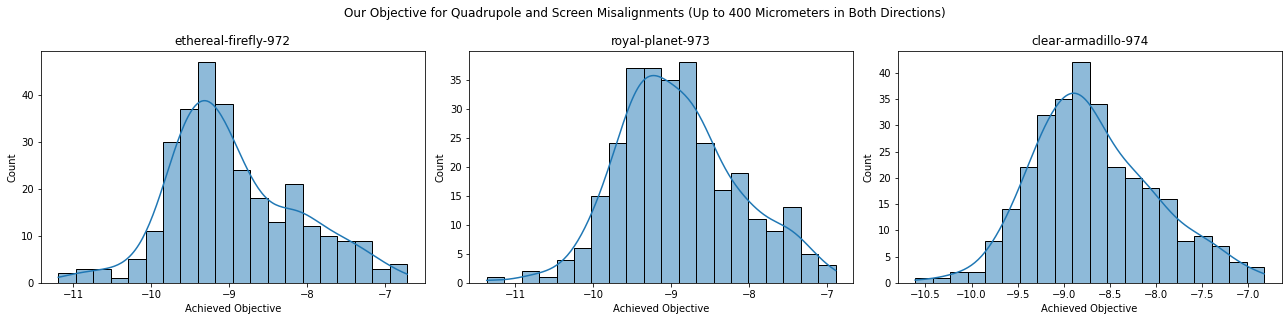

In [27]:
plot_our_objective(evaluations["misalign"], model_type="Quadrupole and Screen Misalignments (Up to 400 Micrometers in Both Directions)")

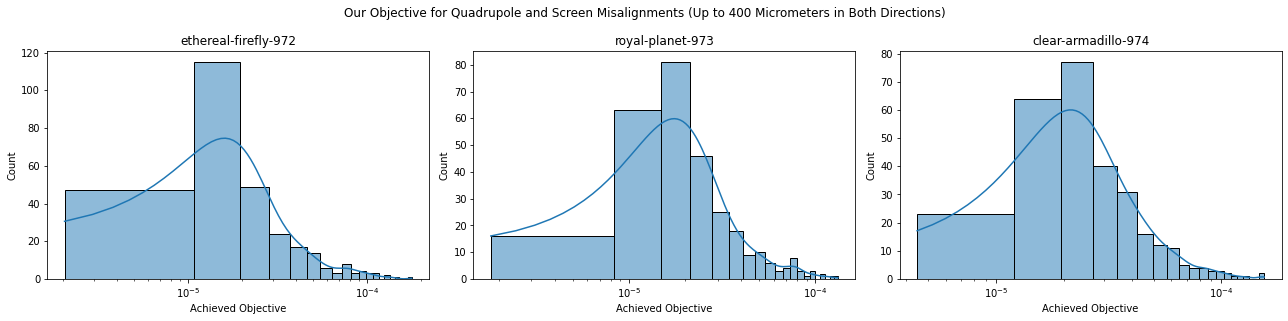

In [28]:
plot_mae(evaluations["misalign"], model_type="Quadrupole and Screen Misalignments (Up to 400 Micrometers in Both Directions)")

## Misalignment-trained Agents Without Misalignments

In [29]:
model_names = ["ethereal-firefly-972", "royal-planet-973", "clear-armadillo-974"]
setups = [load_sequential(model_name) for model_name in model_names]
evaluations["misalignonperfect"] = [evaluate(setup.env, setup.model, problems=problems, model_name=setup.name) for setup in setups]

100%|██████████| 300/300 [00:23<00:00, 12.52it/s]


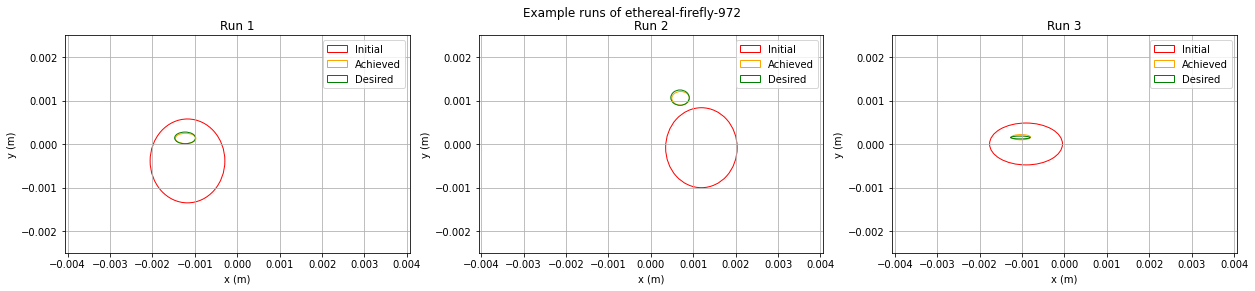

In [30]:
plot_examples(evaluations["misalignonperfect"][0], k=3)

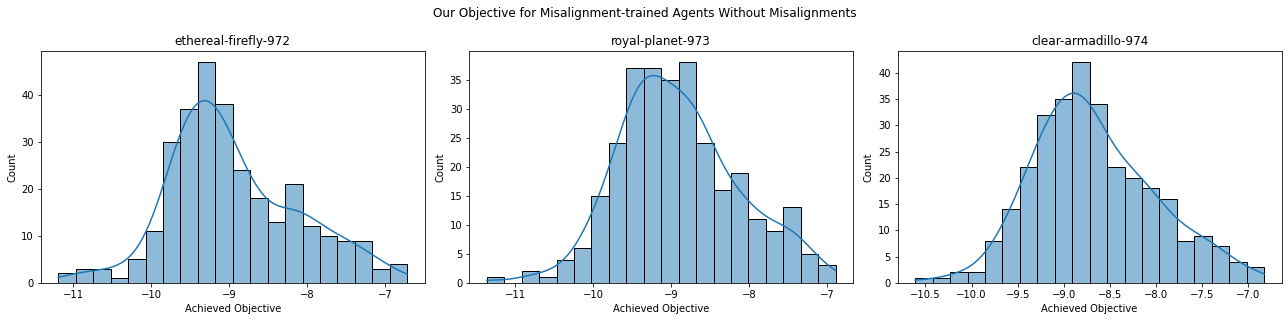

In [31]:
plot_our_objective(evaluations["misalignonperfect"], model_type="Misalignment-trained Agents Without Misalignments")

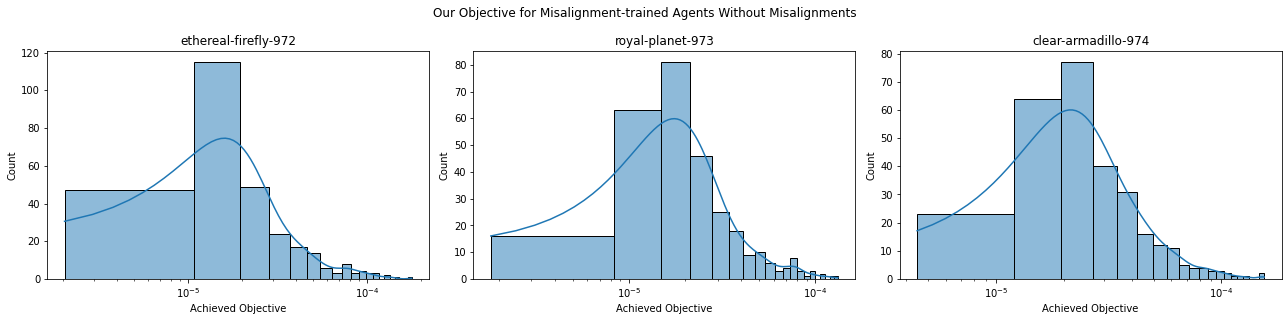

In [32]:
plot_mae(evaluations["misalignonperfect"], model_type="Misalignment-trained Agents Without Misalignments")

## Misalignments Done by No-Misalignment Agents (Trained with Reset Initial Actuators)

In [33]:
model_names = ["faithful-meadow-975", "amber-mountain-976", "ruby-water-977"]
setups = [load_sequential(model_name) for model_name in model_names]
evaluations["misalignbybase"] = [evaluate(setup.env, setup.model, problems=problems, model_name=setup.name) for setup in setups]

100%|██████████| 300/300 [00:22<00:00, 13.35it/s]


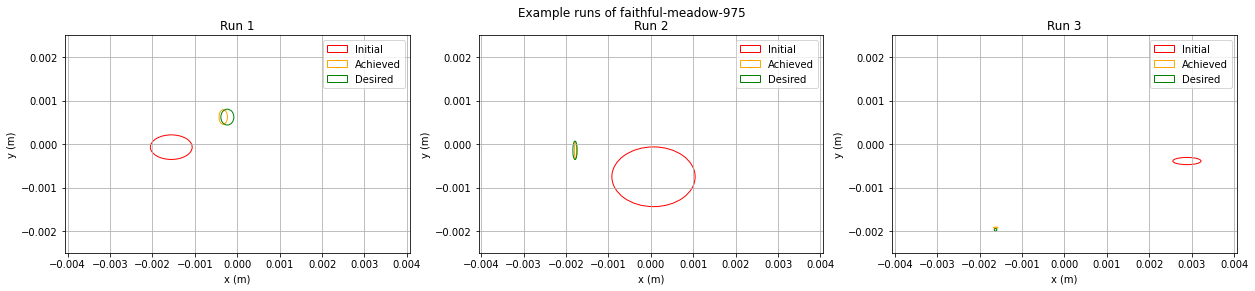

In [34]:
plot_examples(evaluations["misalignbybase"][0], k=3)

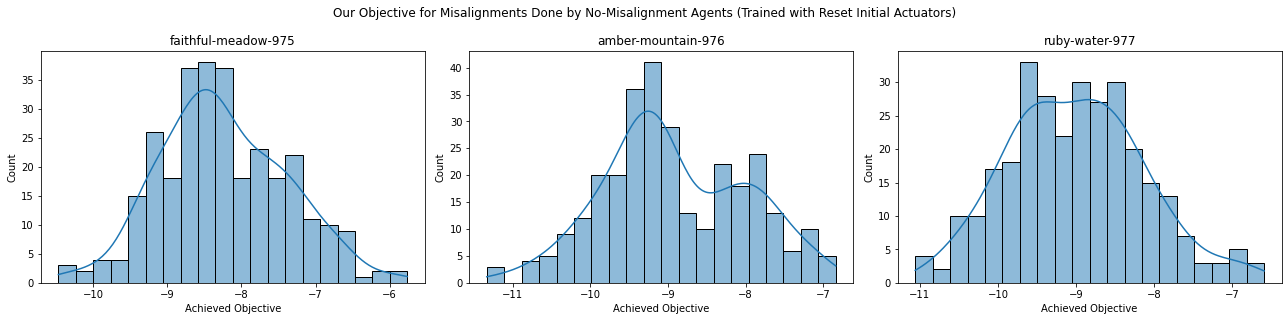

In [35]:
plot_our_objective(evaluations["misalignbybase"], model_type="Misalignments Done by No-Misalignment Agents (Trained with Reset Initial Actuators)")

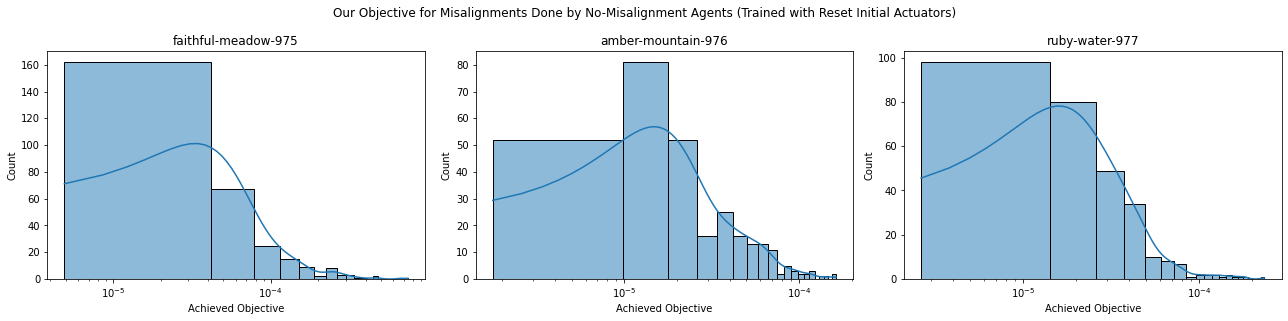

In [36]:
plot_mae(evaluations["misalignbybase"], model_type="Misalignments Done by No-Misalignment Agents (Trained with Reset Initial Actuators)")

## Training for 6M Steps

In [37]:
model_names = ["visionary-blaze-969", "vibrant-leaf-970", "electric-sun-971"]
setups = [load_sequential(model_name) for model_name in model_names]
evaluations["6M"] = [evaluate(setup.env, setup.model, problems=problems, model_name=setup.name) for setup in setups]

100%|██████████| 300/300 [00:19<00:00, 15.12it/s]


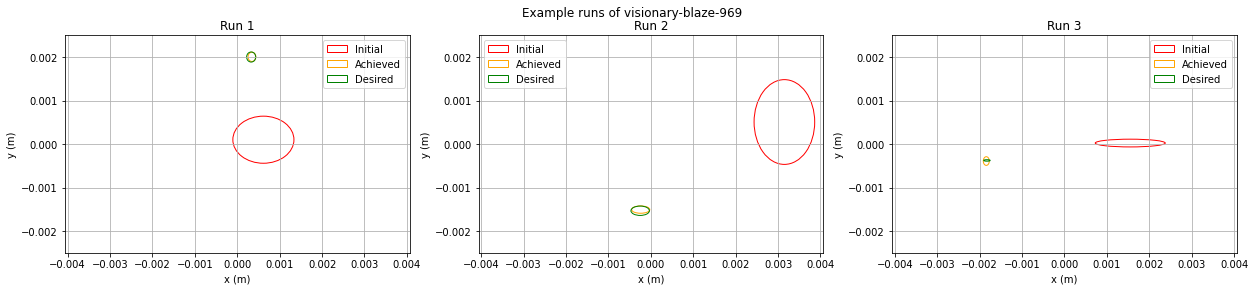

In [38]:
plot_examples(evaluations["6M"][0], k=3)

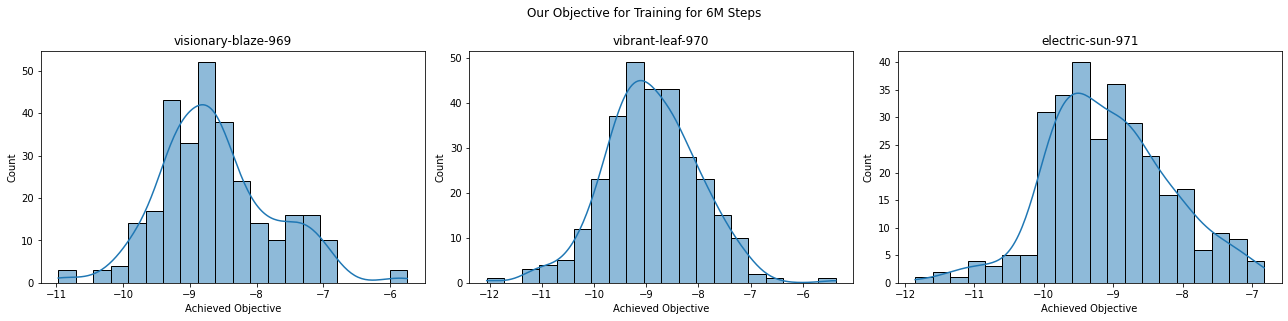

In [39]:
plot_our_objective(evaluations["6M"], model_type="Training for 6M Steps")

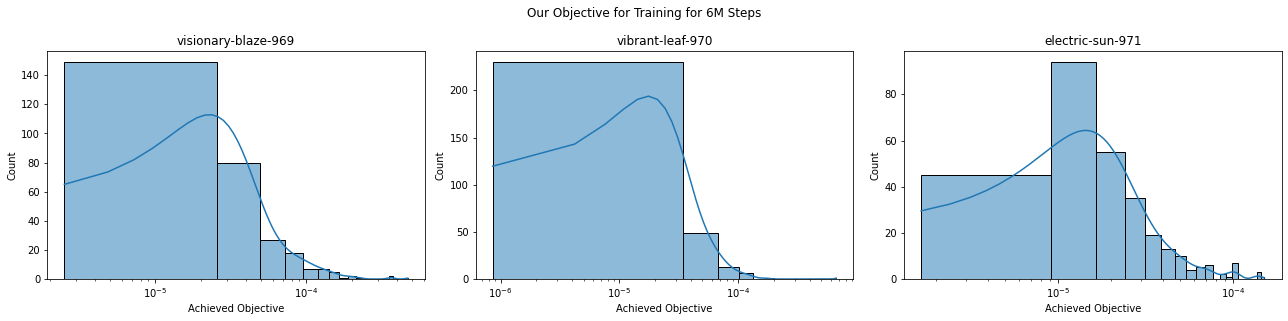

In [40]:
plot_mae(evaluations["6M"], model_type="Training for 6M Steps")

## ------------ SUMMARY ------------

In [57]:
def objective_fn(achieved, desired):
    offset = achieved - desired
    weights = np.array([1, 1, 2, 2])

    return np.log((weights * np.abs(offset)).sum())

agents = []
maes = []
rmses = []
ours = []
for agent, method_evaluation in evaluations.items():
    for agent_evaluation in method_evaluation:
        for result in agent_evaluation.results:
            mae = (np.abs(result.desired - result.achieved)).sum() / 4
            rmse = np.sqrt(((result.desired - result.achieved)**2).sum() / 4)
            our = objective_fn(result.achieved, result.desired)
            
            agents.append(agent)
            maes.append(mae)
            rmses.append(rmse)
            ours.append(our)

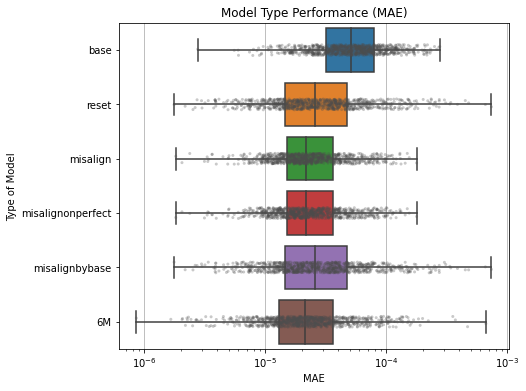

In [58]:
plt.figure(figsize=(7,6))
plt.title("Model Type Performance (MAE)")
sns.boxplot(x=maes, y=agents, whis=(0,100))
sns.stripplot(x=maes, y=agents, size=3, color=".3", alpha=0.3, linewidth=0)
plt.xscale("log")
plt.xlabel("MAE")
plt.ylabel("Type of Model")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.show()

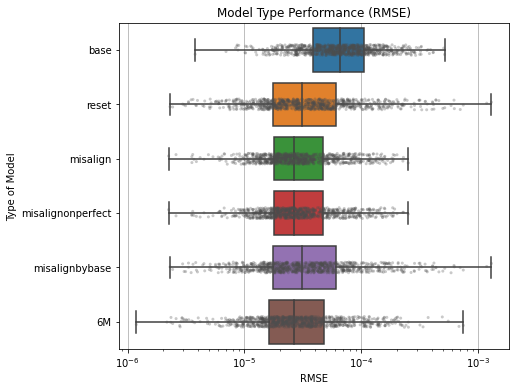

In [59]:
plt.figure(figsize=(7,6))
plt.title("Model Type Performance (RMSE)")
sns.boxplot(x=rmses, y=agents, whis=(0,100))
sns.stripplot(x=rmses, y=agents, size=3, color=".3", alpha=0.3, linewidth=0)
plt.xscale("log")
plt.xlabel("RMSE")
plt.ylabel("Type of Model")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.show()

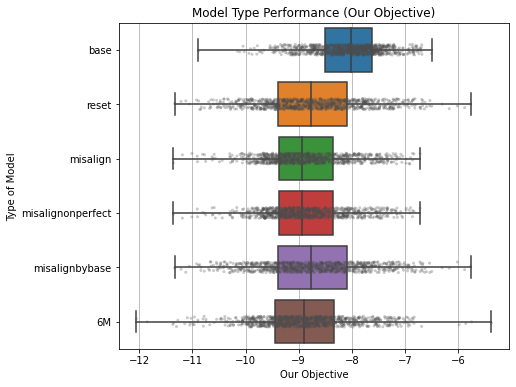

In [60]:
plt.figure(figsize=(7,6))
plt.title("Model Type Performance (Our Objective)")
sns.boxplot(x=ours, y=agents, whis=(0,100))
sns.stripplot(x=ours, y=agents, size=3, color=".3", alpha=0.3, linewidth=0)
plt.xlabel("Our Objective")
plt.ylabel("Type of Model")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.show()

# Onestep

In [2]:
run_name = "happy-snowflake-22"
log_dir = f"models/{run_name}"

def make_env():
    env = ARESEAOneStep(
        backend="simulation",
        backendargs={
            "incoming": "random",
            "beam_parameters": "direct"
        },
        initial="reset",
    )
    env = RescaleAction(env, -1, 1)
    return env

env = DummyVecEnv([make_env])
env = VecNormalize.load(f"{log_dir}/vec_normalize.pkl", env)
env.training = False
env.norm_reward = False

model = PPO.load(f"{log_dir}/model")

In [ ]:
plt.figure(figsize=(21,4))
for i in range(3):
    observation = env.reset()
    desired = env.unnormalize_obs(observation)[0,-8:-4]
    initial = env.unnormalize_obs(observation)[0,-4:]
    done = False
    while not done:
        action, _ = model.predict(observation, deterministic=True)
        observation, reward, done, info = env.step(action)
    achieved = env.unnormalize_obs(info[0]["terminal_observation"])[-4:]

    print(f"{i}: Initial:", initial)
    print(f"{i}: Achieved:", achieved)
    print(f"{i}: Desired:", desired)
    print(f"{i}: Delta:", desired - achieved)
    print(f"{i}: Objective:", env.unwrapped.envs[0].unwrapped._objective_fn(achieved, desired))

    screen = env.get_attr("backend")[0]._segment.AREABSCR1

    plt.subplot(1, 3, i+1)
    plt.title("Beam Parameters")
    plt.xlim([screen.extent[0], screen.extent[1]])
    plt.ylim([screen.extent[2], screen.extent[3]])
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.grid()
    plt.gca().add_patch(Ellipse((initial[0],initial[1]), initial[2], initial[3], fill=False, color="red", label="Initial"))
    plt.gca().add_patch(Ellipse((achieved[0],achieved[1]), achieved[2], achieved[3], fill=False, color="orange", label="Achieved"))
    plt.gca().add_patch(Ellipse((desired[0],desired[1]), desired[2], desired[3], fill=False, color="green", label="Desired"))
    plt.legend()
plt.show()

Initial: [1.18987896e-03 4.67448274e-05 8.64917454e-04 7.98261708e-04]
Achieved: [-0.00038113  0.00095929  0.00012036  0.00026755]
Desired: [-0.00023998  0.00106667  0.00035142  0.00018446]
Delta: [ 1.41146272e-04  1.07375930e-04  2.31059953e-04 -8.30862553e-05]
Objective: -7.0392156
Initial: [-0.00218474  0.00034821  0.00055311  0.00111559]
Achieved: [1.75145451e-03 1.49393473e-03 1.50694765e-05 4.64820385e-04]
Desired: [1.76080740e-03 1.35491304e-03 8.31791301e-05 4.13363188e-04]
Delta: [ 9.35289555e-06 -1.39021697e-04  6.81096536e-05 -5.14571973e-05]
Objective: -7.855774
Initial: [1.84180982e-03 6.17617106e-05 7.34142838e-04 1.91749620e-03]
Achieved: [-1.04425137e-03  6.80781945e-04  3.92363792e-05  3.46629575e-04]
Desired: [-0.00093773  0.0005029   0.00015291  0.00013073]
Delta: [ 0.00010652 -0.00017788  0.00011367 -0.0002159 ]
Objective: -6.9658732


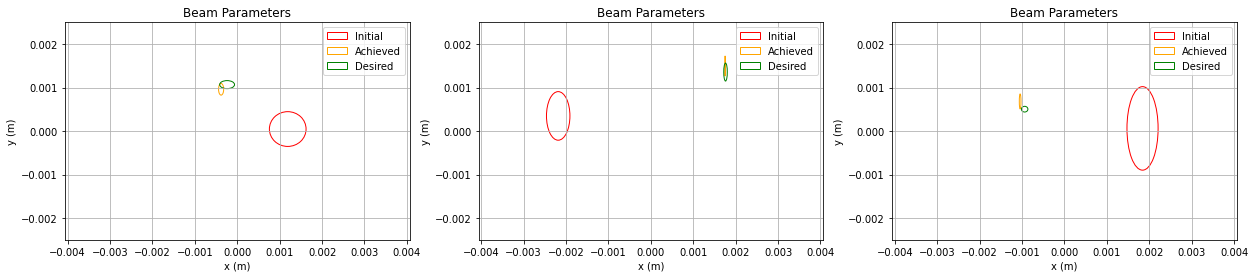

In [8]:
plt.figure(figsize=(21,4))
for i in range(3):
    observation = env.reset()
    desired = env.unnormalize_obs(observation)[0,-8:-4]
    initial = env.unnormalize_obs(observation)[0,-4:]
    action, _ = model.predict(observation, deterministic=True)
    observation, reward, done, info = env.step(action)
    achieved = env.unnormalize_obs(info[0]["terminal_observation"])[-4:]

    print("Initial:", initial)
    print("Achieved:", achieved)
    print("Desired:", desired)
    print("Delta:", desired - achieved)
    print("Objective:", -reward[0])

    screen = env.get_attr("backend")[0]._segment.AREABSCR1

    plt.subplot(1, 3, i+1)
    plt.title("Beam Parameters")
    plt.xlim([screen.extent[0], screen.extent[1]])
    plt.ylim([screen.extent[2], screen.extent[3]])
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.grid()
    plt.gca().add_patch(Ellipse((initial[0],initial[1]), initial[2], initial[3], fill=False, color="red", label="Initial"))
    plt.gca().add_patch(Ellipse((achieved[0],achieved[1]), achieved[2], achieved[3], fill=False, color="orange", label="Achieved"))
    plt.gca().add_patch(Ellipse((desired[0],desired[1]), desired[2], desired[3], fill=False, color="green", label="Desired"))
    plt.legend()
plt.show()

In [9]:
def evaluate(run_name, n=100):
    log_dir = f"models/{run_name}"

    def make_env():
        env = ARESEAOneStep(
            backend="simulation",
            backendargs={
                "incoming": "random",
                "beam_parameters": "direct"
            },
            initial="reset",
        )
        env = RescaleAction(env, -1, 1)
        return env

    env = DummyVecEnv([make_env])
    env = VecNormalize.load(f"{log_dir}/vec_normalize.pkl", env)
    env.training = False
    env.norm_reward = False

    model = PPO.load(f"{log_dir}/model")

    objectives = []
    for _ in range(n):
        observation = env.reset()
        action, _ = model.predict(observation, deterministic=True)
        observation, reward, done, info = env.step(action)
        objectives.append(-reward[0])
    
    return objectives

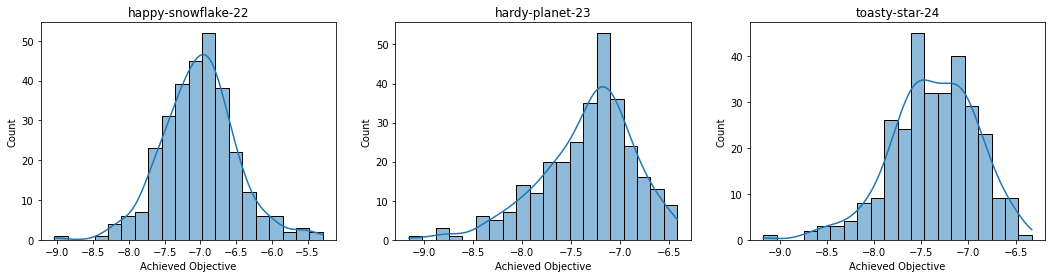

In [10]:
run_names = ["happy-snowflake-22", "hardy-planet-23", "toasty-star-24"]
results = [evaluate(run_name, n=300) for run_name in run_names]

plt.figure(figsize=(18,4))
for i, (run_name, result) in enumerate(zip(run_names, results)):
    plt.subplot(1, len(run_names), i+1)
    plt.title(run_name)
    sns.histplot(result, bins=20, kde=True)
    plt.xlabel("Achieved Objective")
plt.show()